In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.ndimage.interpolation import shift
from scipy.signal import decimate
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
import pickle

In C:\Users\francescag\AppData\Local\Continuum\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\francescag\AppData\Local\Continuum\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\francescag\AppData\Local\Continuum\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
def rolling_zscore(x, window=10*10000):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

In [3]:
mouse = 'SNL_photo17'
date = '20200204'
saving_folder = 'W:\\photometry_2AC\\processed_data\\' + mouse + '\\'
restructured_data_filename = mouse + '_' + date + '_' + 'restructured_data.pkl'
trial_data = pd.read_pickle(saving_folder + restructured_data_filename) 
dff_trace_filename = mouse + '_' + date + '_' + 'smoothed_signal.npy'
dff = np.load(saving_folder + dff_trace_filename)

In [4]:
window_size_seconds = 10
sample_rate = 10000
decimate_factor = 100

In [5]:
rolling_zscored_dff = rolling_zscore(pd.Series(dff), window=window_size_seconds*sample_rate)

In [6]:
rolling_zscored_dff.shape

(45755000,)

In [10]:
downsampled_zscored_dff = decimate(decimate(rolling_zscored_dff[window_size_seconds*sample_rate:], int(decimate_factor/10)), int(decimate_factor/10))

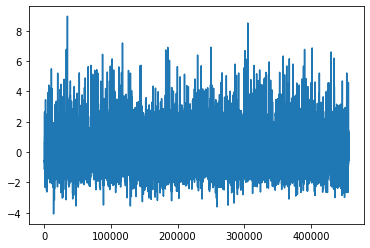

In [11]:
plt.plot(downsampled_zscored_dff)

In [12]:
num_samples = downsampled_zscored_dff.shape[0]

In [13]:
def turn_timestamps_into_continuous(num_samples, *behavioural_events):
    continuous_parameters = []
    for event_type_timestamps in behavioural_events:
        continuous_time_version = np.zeros([num_samples])
        continuous_time_version[event_type_timestamps] = 1
        continuous_parameters.append(continuous_time_version)
    return continuous_parameters

In [14]:
aligned_filename = mouse + '_' + date + '_' + 'aligned_traces.p'
save_filename = saving_folder + aligned_filename
example_session_data = pickle.load(open(save_filename, "rb"))

In [15]:
def convert_behavioural_timestamps_into_samples(time_stamps, window_to_remove, sample_rate=10000, decimate_factor=100):
    return np.round((time_stamps - window_size_seconds)*sample_rate/decimate_factor).astype(int)

In [16]:
ipsi_choices = convert_behavioural_timestamps_into_samples(example_session_data.choice_data.ipsi_data.event_times, 10)
contra_choices = convert_behavioural_timestamps_into_samples(example_session_data.choice_data.contra_data.event_times, 10)
ipsi_cues = convert_behavioural_timestamps_into_samples(example_session_data.cue_data.ipsi_data.event_times, 10)
contra_cues = convert_behavioural_timestamps_into_samples(example_session_data.cue_data.contra_data.event_times, 10)

In [17]:
parameters = turn_timestamps_into_continuous(num_samples, ipsi_choices, contra_choices, ipsi_cues, contra_cues)

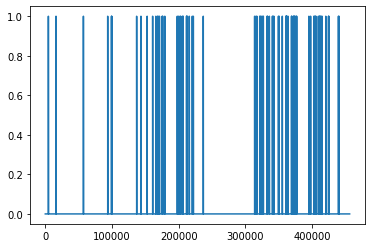

In [18]:
plt.plot(parameters[3])

In [23]:
def make_design_matrix(parameters, window_min=-1*10000/100, window_max=2*10000/100):
    num_parameters = len(parameters)
    shifts = np.arange(window_min, window_max + 1)
    shift_window_size = shifts.shape[0]
    X = np.zeros([parameters[0].shape[0], shift_window_size*num_parameters])
    all_param_indices = []
    for shift_num, shift_val in  enumerate(shifts):
        for param_num, param in enumerate(parameters):
            param_indices = range(param_num*shift_window_size, param_num*shift_window_size + shift_window_size)
            all_param_indices.append(param_indices)
            shifted_param = shift(param, shift_val, cval=0) 
            X[:, param_indices[shift_num]] = shifted_param
    return(all_param_indices, X)


In [24]:
all_param_indices, X = make_design_matrix(parameters)

In [25]:
results = LinearRegression().fit(X, downsampled_zscored_dff)

In [28]:
def plot_kernels(parameter_names, regression_results,window_min=-1*10000/100, window_max=2*10000/100):
    
    fig, axs = plt.subplots(nrows=1, ncols=len(parameter_names), sharey=True)
    
    shifts = np.arange(window_min, window_max + 1)
    shift_window_size = shifts.shape[0]
    for param_num, param_name in enumerate(parameter_names):
        param_kernel = regression_results.coef_[param_num*shift_window_size:(param_num+1)*shift_window_size]
        axs[param_num].plot(shifts, param_kernel, label=param_name)
        axs[param_num].set_title(param_name)

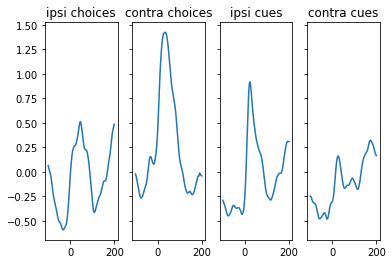

In [29]:
param_names = ['ipsi choices', 'contra choices', 'ipsi cues', 'contra cues']
plot_kernels(param_names, results)

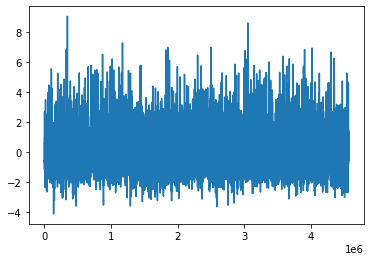

In [50]:
plt.plot(downsampled_zscored_dff)